In [8]:
import torch
from models.resnetv2 import ResNet50
from torchvision import transforms
from PIL import Image
from melanoma.melanoma_loader import Melanoma_loader
from zennit.composites import EpsilonPlusFlat
from zennit.torchvision import ResNetCanonizer
from crp.attribution import CondAttribution
from crp.concepts import ChannelConcept
from crp.image import imgify

In [9]:
from PIL import Image

WIDTH = 256
HEIGHT = 256
ROOT = "melanoma/data/train/train/"

def stacked_img(img_path, extra_img):
    img = Image.open(ROOT + img_path + ".jpg")

    new_im = Image.new('RGB', (2 * WIDTH, HEIGHT))
    new_im.paste(img, (0, 0))
    new_im.paste(extra_img, (WIDTH, 0))
    return new_im

def show_sample(img_path):
    img = Image.open(ROOT + img_path + ".jpg")
    return img

def iterate_class(dataset, find_melanoma=1):
    for idx in range(len(dataset)):
        if dataset[idx][1] == find_melanoma:
            yield dataset[idx][0].view(1, 3, 256, 256), dataset.lookup_path(idx)

path_to_model = 'model_melanoma'

model = ResNet50(out_features = 2, freeze = True, in_channels = 3)
checkpoint1 = torch.load(path_to_model, map_location='cpu')
model.load_state_dict(checkpoint1['model'], strict=False)
model.eval()

make_dataset = lambda: Melanoma_loader(root = "melanoma/data/train/train", ann_path = "melanoma/data/test_set.csv",
                          transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((256, 256)),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]))

melanoma_generator = iterate_class(make_dataset(), find_melanoma=1)
nonmelanoma_generator = iterate_class(make_dataset(), find_melanoma=0)

In [10]:
concept_ids = [0, 1, 10, 15, 32] # those are no of channels which we look at (used to define conditions)
conditions = [{'backbone.layer4.2.conv3': [ids], 'y': [1]} for ids in concept_ids]

## Incorrect implementation

True 0


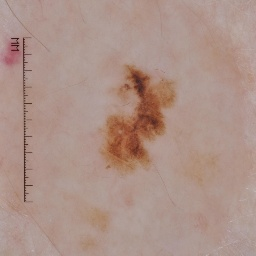

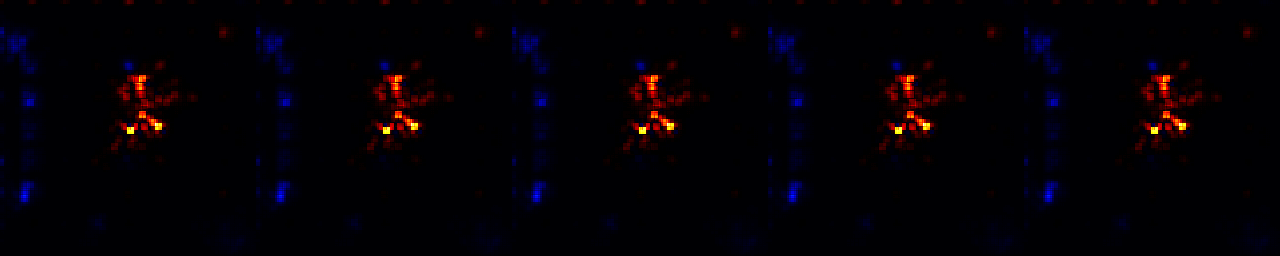

: 

In [16]:
cc = ChannelConcept()
attribution = CondAttribution(model)

# test_tensor, path = next(melanoma_generator)

# use the ResNet-specific canonizer
canonizer = ResNetCanonizer()

# create a composite, specifying the canonizers
composite = EpsilonPlusFlat(canonizers=[canonizer])

# zennit requires gradients
test_tensor.requires_grad = True


attr = attribution(test_tensor, conditions, composite)
heatmaps, _, _, _ = attribution(test_tensor, conditions, composite)

print(torch.equal(attr[0], heatmaps), 0)

img = imgify(heatmaps, symmetric=True, cmap='coldnhot', grid=(1, len(heatmaps)))
display(show_sample(path))
display(img)
                   

## Corrected implementation

In [12]:
from zennit.canonizers import SequentialMergeBatchNorm, AttributeCanonizer, CompositeCanonizer
from zennit.torchvision import ResNetBottleneckCanonizer, ResNetBasicBlockCanonizer
from torchvision.models.resnet import Bottleneck as ResNetBottleneck
from zennit.layer import Sum

class HackBottleneckCanonizer(ResNetBottleneckCanonizer):
    def __init__(self, overwrite_names):
        AttributeCanonizer.__init__(self, self.get_attribute_map(overwrite_names))
        
    
    @classmethod
    def get_attribute_map(cls, overwrite_names):
        
        def _attribute_map(name, module):
            if isinstance(module, ResNetBottleneck):
                if name in overwrite_names:
                    attributes = {
                        'forward': cls.forward_no_grad.__get__(module),
                        'canonizer_sum': Sum(),
                    }
                    return attributes
                else:
                    attributes = {
                        'forward': cls.forward.__get__(module),
                        'canonizer_sum': Sum(),
                    }
                    return attributes
                return None
        return _attribute_map
    
    @staticmethod
    def forward_no_grad(self, x):
        '''
        Modified Bottleneck forward for HackResNet.
        This forward doesn't propagate gradient through skip connections of given layers.
        '''
        identity = x.clone().detach()
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)
            
        out = torch.stack([identity, out], dim=-1)
        out = self.canonizer_sum(out)

        out = self.relu(out)

        return out


class HackCanonizer(CompositeCanonizer):
    def __init__(self, grad_omit_skips):
        super().__init__((
            SequentialMergeBatchNorm(),
            HackBottleneckCanonizer(grad_omit_skips),
            ResNetBasicBlockCanonizer(),
        ))


def get_canonizer(conditions):
    masked_skips = set()
    for condition in conditions:
        for layer_name in condition.keys():
            if layer_name.startswith("backbone.layer"):
                masked_skips.add(layer_name[:len("backbone.layer") + 3])
    return [HackCanonizer(list(masked_skips))]

True 0


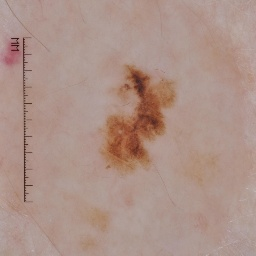

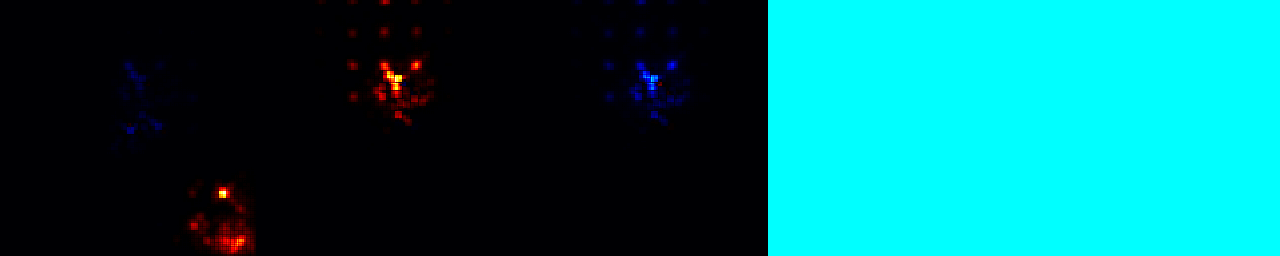

In [15]:
cc = ChannelConcept()
attribution = CondAttribution(model)

test_tensor, path = next(melanoma_generator)

# concept_ids = list(range(4))
# conditions = [{'layer1.0.conv1': [ids], 'y': [1]} for ids in concept_ids]

# use the ResNet-specific canonizer
canonizer = get_canonizer(conditions)


# create a composite, specifying the canonizers
composite = EpsilonPlusFlat(canonizers=get_canonizer(conditions))


# zennit requires gradients
test_tensor.requires_grad = True

heatmaps, _, _, _ = attribution(test_tensor, conditions, composite)

img = imgify(heatmaps, symmetric=True, cmap='coldnhot', grid=(1, len(heatmaps)))
display(show_sample(path))
display(img)